# Air quality impact on hives survival 

The dataset is from Nectar 1.19 and cover hives from 2020 to 2023. The 2023 season is currently censored in terms of winter mortality but you can analyse the acute effect (which I didn't include in the blog post but I did have a look at the effect on the summer mortality and the effect are even stronger). I also shared the complete daily history for all the yards in the dataset for air quality , ndvi and weather that was scrapped from Airpyllution package, meteostats package and earth engine. Finally, you will find a file called 'ops_meta.csv' which contains the region of the given operations. 

The file are found on this google drive: [here](https://drive.google.com/drive/u/0/folders/1UZ3_jzMRdaQEaIR1TzPqEWTb0azECStB)


***
### SETUP

In [1]:
import os 
import ast
from datetime import datetime, date,timezone, timedelta

import pandas as pd 
import numpy as np
from collections import Counter

import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
%matplotlib inline 

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis
from pymer4.models import Lmer
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import RandomizedSearchCV

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

NECTAR_PALETTE = "blend:#D8A348,#1D1D1D"
sns.set_palette(NECTAR_PALETTE)

ROOT_PATH = "../data"
SEASONS_INCLUDED = [2021, 2022, 2023]
FEATURES_MONTH = [5,6,7,8]
RUN_PREPROCESS = False

START_SEASON_MONTH = 6
START_SEASON_DAY = 15
END_SEASON_MONTH = 11
END_SEASON_DAY = 15

# OPS USED 
OPS = (36, 51, 55, 69, 83, 87, 89, 153, 159, 160, 161, 167, 192, 193, 194, 195, 199, 205, 207, 208, 210, 212, 218, 219, 220, 221)

In [2]:
from aqi.data.utils import timestamp_to_date, try_check_month
from aqi.vizualisation.utils import plot_survival_bar_per_state

In [3]:

if RUN_PREPROCESS:
    d = pd.read_csv(os.path.join(ROOT_PATH,"raw_dev.csv"))
    d['death_date'] = pd.to_datetime(d['death_date'],format="mixed")
    d['creation_date'] = pd.to_datetime(d['creation_date'],format="mixed")

    for season in SEASONS_INCLUDED:
    
        season_end = date(season,END_SEASON_MONTH,END_SEASON_DAY)
        last_season_end = date(season-1,END_SEASON_MONTH,END_SEASON_DAY)
        season_start = date(season,START_SEASON_MONTH,START_SEASON_DAY)
    
        next_season_start = date(season+1,START_SEASON_MONTH,START_SEASON_DAY)
    
        state_logs = d.copy()
        state_logs["death_date"]= state_logs["death_date"].fillna(next_season_start)
        state_logs["death_date"] = pd.to_datetime(state_logs["death_date"]).dt.tz_localize(None)
        state_logs["creation_date"] = pd.to_datetime(state_logs["creation_date"]).dt.tz_localize(
            None
        )
       
        created_during_season = (state_logs["creation_date"].dt.date < season_end) 
        # Died after the season start but was alive before
        died_after_season_start = state_logs["death_date"].dt.date > season_start
        # Died before the next season 
        died_before_next_season_start = state_logs["death_date"].dt.date <= next_season_start #+ timedelta(days=BUFFER)
        # Exclude hive created betwween season start and that die before also 
        didnt_see_summer = ~((state_logs.apply(lambda x: x["death_date"].month in [1,2,3,4,5] ,axis=1)) & (state_logs["creation_date"].dt.date > season_end))
    
        
        subset_state = state_logs.loc[created_during_season & died_after_season_start & died_before_next_season_start & didnt_see_summer]
        subset_state['season'] = season
        # Also replace death date > then end_of_exp because otherwise bias model (age)
        subset_state.loc[pd.to_datetime(subset_state['death_date']).dt.date > next_season_start, 'death_date'] = next_season_start
        
        if season == SEASONS_INCLUDED[0]:
            data = subset_state 
        else:
            data = pd.concat([data,subset_state],axis=0)
    data.reset_index(drop=True,inplace=True)
    data.to_csv(os.path.join(ROOT_PATH,"merged_dev.csv"),index=False)

***
### LOADING DATA

In [4]:
if RUN_PREPROCESS:
    operation_meta = pd.read_csv(os.path.join(ROOT_PATH,"ops_meta.csv"))
    aqi = pd.read_csv(os.path.join(ROOT_PATH,"aqi_dev.csv"))
    weather = pd.read_csv(os.path.join(ROOT_PATH,"weather_dev.csv"))
    ee = pd.read_csv(os.path.join(ROOT_PATH,"ee_dev.csv"))
    ee.drop("ee-image",axis=1,inplace=True)
    ee.dropna(subset=["ndvi"],inplace=True)
    
    mov = pd.read_csv(os.path.join(ROOT_PATH,"mouvements.csv"))

    data = pd.read_csv(os.path.join(ROOT_PATH,"merged_dev.csv"))
else:
    data = pd.read_csv(os.path.join(ROOT_PATH,"preprocess.csv"))
data['death_date'] = pd.to_datetime(data['death_date'], format='mixed')
data = data.loc[data['season'].isin(SEASONS_INCLUDED)]

In [5]:
# sns.set_palette("tab10")
# for ops in d.operation_id.unique():
#     if ops in [55,161,69]:
#         sub = d.loc[d['operation_id']==ops]
#         sns.histplot(sub.death_date.dt.month, label=str(ops))
# plt.legend()

In [6]:
sns.set_palette(NECTAR_PALETTE)

In [7]:
if RUN_PREPROCESS:
    print(weather.isnull().mean()) # For some reason atmost pressure is not getting scrapped 

In [8]:
if RUN_PREPROCESS:
    print(aqi.isnull().mean())

In [9]:
if RUN_PREPROCESS:
    print(ee.isnull().mean()) # 2023 is null , need to update for simulations later...

In [10]:
if RUN_PREPROCESS:
    print(ee.head())

In [11]:
if RUN_PREPROCESS:
    data['creation_date'] = pd.to_datetime(data['creation_date'],format='mixed').dt.date
    data['death_date']= pd.to_datetime(data['death_date']).dt.date

In [12]:
if RUN_PREPROCESS:
    print(Counter(data.hid.value_counts())) # Meaning that 16 632 hives are present in two season while 38405 are only in one season 

In [13]:
if RUN_PREPROCESS:
    ### Label creation (based on season start end)
    
    def get_state_for_season(state_log):
        
        return state_log.apply(lambda x: x['death_date'] < date(x['season']+1, START_SEASON_MONTH,START_SEASON_DAY), axis=1)
    
    def get_age_for_season(state_log):
        return state_log.apply(lambda x : abs((x['death_date'] - x['creation_date']).days), axis=1)
    
    
    data['death_next_season'] = get_state_for_season(data)
    data['hive_age_next_season'] = get_age_for_season(data)

In [14]:
data['death_next_season'].mean()

0.19865503205869942

In [15]:
data.dtypes

hid                              int64
creation_date                   object
operation_id                     int64
death_date              datetime64[ns]
season                           int64
death_next_season                 bool
hive_age_next_season             int64
aqhi_average                   float64
prcp_average                   float64
wspd_average                   float64
ndvi_average                   float64
tavg_average                   float64
o3_average                     float64
aqhi_skew                      float64
prcp_skew                      float64
wspd_skew                      float64
ndvi_skew                      float64
tavg_skew                      float64
o3_skew                        float64
aqhi_max                       float64
prcp_max                       float64
wspd_max                       float64
ndvi_max                       float64
tavg_max                       float64
o3_max                         float64
region                   

In [16]:
data.operation_id.value_counts()

operation_id
193    44495
69     32987
153    18268
55     14613
167     9544
161     8070
207     5822
87      4589
210     1828
195     1591
36      1084
194      973
212      758
220      631
160      407
219      397
224      251
159      227
205      193
83       188
199        2
Name: count, dtype: int64

In [17]:
data.season.value_counts()

season
2023    107999
2022     30931
2021      7988
Name: count, dtype: int64

In [18]:
if RUN_PREPROCESS:
    # BAD OPS in 2021-2022
    data = data.loc[~((data['operation_id'] == 51) & (data['season']==2021))]
    data = data.loc[~((data['operation_id'] == 87) & (data['season']==2021))]
    data = data.loc[~((data['operation_id']==167) & (data['season']==2022))]

In [19]:
data.drop(['death_date','creation_date'],axis=1).groupby(['season','operation_id']).mean(numeric_only=True)[['death_next_season','hive_age_next_season']]

death_next_season  hive_age_next_season
season operation_id                                         
2021   36                     0.492355            411.103976
       55                     0.623086            321.406164
       69                     0.661955            350.359246
       83                     0.000000            322.000000
2022   36                     0.028646            552.833333
       55                     0.315020            559.845148
       69                     0.337974            366.455468
       83                     0.552632            399.657895
       87                     0.647992            412.726216
       153                    0.416810            389.562950
       159                    0.704348            298.669565
       160                    0.248276            325.255172
       161                    0.283731            289.159781
2023   36                     0.000000            927.525469
       55                     0.046553            724.146454
       69                     0.128808            527.610175
       83                     0.055556            835.666667
       87                     0.151279            459.447534
       153                    0.036438            588.966082
       159                    0.062500            468.455357
       160                    0.064885            498.583969
       161                    0.029163            514.239139
       167                    0.132754            350.405909
       193                    0.139117            436.991190
       194                    0.038027            314.704008
       195                    0.037712            327.542426
       199                    0.000000            437.500000
       205                    0.000000            370.248705
       207                    0.219684            280.761079
       210                    0.066193            321.088074
       212                    0.325858            234.492084
       219                    0.032746            259.450882
       220                    0.020602            247.294770
       224                    0.000000            240.972112

In [20]:
len(data)

146918

In [21]:
data.isnull().mean()

hid                     0.000000
creation_date           0.000000
operation_id            0.000000
death_date              0.000000
season                  0.000000
death_next_season       0.000000
hive_age_next_season    0.000000
aqhi_average            0.042827
prcp_average            0.042827
wspd_average            0.042827
ndvi_average            0.071046
tavg_average            0.042827
o3_average              0.042827
aqhi_skew               0.043745
prcp_skew               0.055112
wspd_skew               0.043745
ndvi_skew               0.757722
tavg_skew               0.043664
o3_skew                 0.043745
aqhi_max                0.042827
prcp_max                0.042827
wspd_max                0.042827
ndvi_max                0.071046
tavg_max                0.042827
o3_max                  0.042827
region                  0.000000
dtype: float64

### Feature eng for predictive models


### From mouvements to sensors data 

- Idea is to get the location of the hive at time X between june 1st and August 31 
- Once we have that info we simply do statistic on the sequence 


***
### One hive example

In [22]:
if RUN_PREPROCESS:
    mov['to_when'].fillna(date.today(),inplace=True) # When null still didn't moved
    mov['from_when'] = pd.to_datetime(mov['from_when'],format='mixed').dt.date
    mov['to_when'] = pd.to_datetime(mov['to_when'],format='mixed').dt.date
    
    aqi['time'] = pd.to_datetime(aqi['time'],format='mixed').dt.date
    weather['time'] = pd.to_datetime(weather['time'],format='mixed').dt.date
    ee['time'] = pd.to_datetime(ee['time'],format='mixed').dt.date

In [23]:
if RUN_PREPROCESS:
    # Only keep aqi, weather and ee for summer month 
    
    aqi = aqi.loc[pd.to_datetime(aqi['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)
    weather = weather.loc[pd.to_datetime(weather['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)
    ee = ee.loc[pd.to_datetime(ee['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)

In [24]:
if RUN_PREPROCESS:
    one = mov.loc[mov['hive_identity_id']==21199]
    print(len(one))

In [25]:
if RUN_PREPROCESS:
    one = (one.assign(time = [pd.date_range(start, end) 
                       for start, end 
                       in zip(one['from_when'], one['to_when'])]
              )
       .explode('time', ignore_index = True)
    )

In [26]:
if RUN_PREPROCESS:
    one['time'] = pd.to_datetime(one['time']).dt.date

In [27]:
if RUN_PREPROCESS:
    one.head()

In [28]:
if RUN_PREPROCESS:
    one = pd.merge(one,aqi, on=["yard_id","time"])

In [29]:
if RUN_PREPROCESS:
    one['season'] = pd.to_datetime(one['time']).dt.year
    one['month'] = pd.to_datetime(one['time']).dt.month

In [30]:
if RUN_PREPROCESS:
    one[['season','month','aqhi']].groupby(["season","month"]).mean()

In [31]:
if RUN_PREPROCESS:
    print(one.head())

### ALL hives and sensors

In [32]:
if RUN_PREPROCESS:
    mov = mov[mov['hive_identity_id'].isin(list(data.hid.unique()))].reset_index(drop=True)

In [33]:
if RUN_PREPROCESS:
    # WARNING THIS TAKES A WHILE (5 minutes...or so)
    mov = (mov.assign(time = [pd.date_range(start,end) 
                       for start, end 
                       in zip(mov['from_when'], mov['to_when'])]
              )
       .explode('time', ignore_index = True)
    )

In [34]:
if RUN_PREPROCESS:
    mov['time'] = pd.to_datetime(mov['time']).dt.date
    
    mov = mov.loc[pd.to_datetime(mov['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)

In [35]:
if RUN_PREPROCESS:
    merged = pd.merge(mov,aqi, on=["yard_id","time"], how="left")
    merged = pd.merge(merged,weather, on=["yard_id","time"], how="left")
    merged = pd.merge(merged,ee, on=["yard_id","time"], how="left")
    merged.sort_values("time",ascending=True,inplace=True)
    # Keep value constant if no change 
    merged.fillna(method="bfill",inplace=True)
    
    merged.head()

In [36]:
if RUN_PREPROCESS:
    merged.isnull().mean()

### TSun and Wdir high null, just ignore them 

In [37]:
if RUN_PREPROCESS:
    merged.drop(['tsun','wdir'],axis=1,inplace=True)

### Compute stats for each hid

In [38]:
if RUN_PREPROCESS:
    merged['season'] = pd.to_datetime(merged['time']).dt.year

In [39]:
if RUN_PREPROCESS:
    # THis takes 10 min or so locally
    # merged['month'] = pd.to_datetime(merged['time']).dt.month
    averages = merged.drop(['from_when','to_when','time','submitted_at'],axis=1).groupby(["hive_identity_id","season"]).mean().reset_index()
    skewed = merged.drop(['from_when','to_when','time','submitted_at'],axis=1).groupby(["hive_identity_id","season"]).agg(lambda x : skew(x)).reset_index()
    maxed = merged.drop(['from_when','to_when','time','submitted_at'],axis=1).groupby(["hive_identity_id","season"]).max().reset_index()
    mode = merged.drop(['from_when','to_when','time','submitted_at'],axis=1).groupby(["hive_identity_id","season"]).mode().reset_index()

In [40]:
if RUN_PREPROCESS:
    averages.rename(columns={"aqhi":"aqhi_average","prcp":"prcp_average","wspd":"wspd_average","ndvi":"ndvi_average"
                             ,"tavg":"tavg_average","o3":"o3_average","hive_identity_id":"hid"},inplace=True)
    skewed.rename(columns={"aqhi":"aqhi_skew","prcp":"prcp_skew","wspd":"wspd_skew","ndvi":"ndvi_skew"
                           ,"tavg":"tavg_skew","o3":"o3_skew","hive_identity_id":"hid"},inplace=True)
    maxed.rename(columns={"aqhi":"aqhi_max","prcp":"prcp_max","wspd":"wspd_max","ndvi":"ndvi_max"
                          ,"tavg":"tavg_max","o3":"o3_max","hive_identity_id":"hid"},inplace=True)
    mode.rename(columns={"aqhi":"aqhi_max","prcp":"prcp_max","wspd":"wspd_max","ndvi":"ndvi_max"
                          ,"tavg":"tavg_max","o3":"o3_max","hive_identity_id":"hid"},inplace=True)


### Bring remote sensors with season state (merge)

In [41]:
if RUN_PREPROCESS:
    print(len(data))
    data = pd.merge(data, averages[['season','hid','aqhi_average','prcp_average','wspd_average'
                                    ,'ndvi_average','tavg_average','o3_average']], on=["season","hid"], how="left")
    print(len(data))
    data = pd.merge(data, skewed[['season','hid','aqhi_skew','prcp_skew','wspd_skew'
                                  ,'ndvi_skew','tavg_skew','o3_skew']], on=["season","hid"], how="left")
    print(len(data))
    data = pd.merge(data, maxed[['season','hid','aqhi_max','prcp_max','wspd_max'
                                 ,'ndvi_max','tavg_max','o3_max']], on=["season","hid"], how="left")
    print(len(data))
    data = pd.merge(data, mode[['season','hid','aqhi_max','prcp_max','wspd_max'
                                 ,'ndvi_max','tavg_max','o3_max']], on=["season","hid"], how="left")

In [42]:
data.head()

,hid,creation_date,operation_id,death_date,season,death_next_season,hive_age_next_season,aqhi_average,prcp_average,wspd_average,...,ndvi_skew,tavg_skew,o3_skew,aqhi_max,prcp_max,wspd_max,ndvi_max,tavg_max,o3_max,region
0,21199,2021-06-23,55,2022-06-15,2021,False,357,3.144167,2.181429,7.657143,...,-0.238451,0.046882,1.101650,6.666667,54.8,16.8,0.643625,27.6,98.319167,QC
1,38198,2021-09-27,55,2022-06-15,2021,False,261,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QC
2,22571,2021-07-28,83,2022-06-15,2021,False,322,3.814286,0.634286,7.145714,...,2.067767,-0.123295,0.387849,6.500000,12.2,12.7,0.465664,27.6,82.120000,QC
3,19339,2021-06-18,69,2022-06-15,2021,False,362,3.754870,1.185714,10.190909,...,-0.312115,-0.246683,0.594465,9.958333,20.0,19.0,0.606795,26.1,109.256250,AB
4,19340,2021-06-18,69,2022-06-15,2021,False,362,3.747835,1.185714,10.190909,...,-0.312115,-0.246683,0.610503,9.958333,20.0,19.0,0.606795,26.1,109.256250,AB


In [43]:
len(data)

146918

In [44]:
data.loc[data['season'].isin([2021,2022])]['death_next_season'].mean()

0.4217477324700018

In [45]:
data['death_next_season'].mean()

0.19865503205869942

In [46]:
len(data.operation_id.unique())

21

In [47]:
np.sum(data.hid.value_counts() > 1)

19538

In [48]:
len(data.hid.unique())

124413

In [49]:
2.99/3.51

0.851851851851852

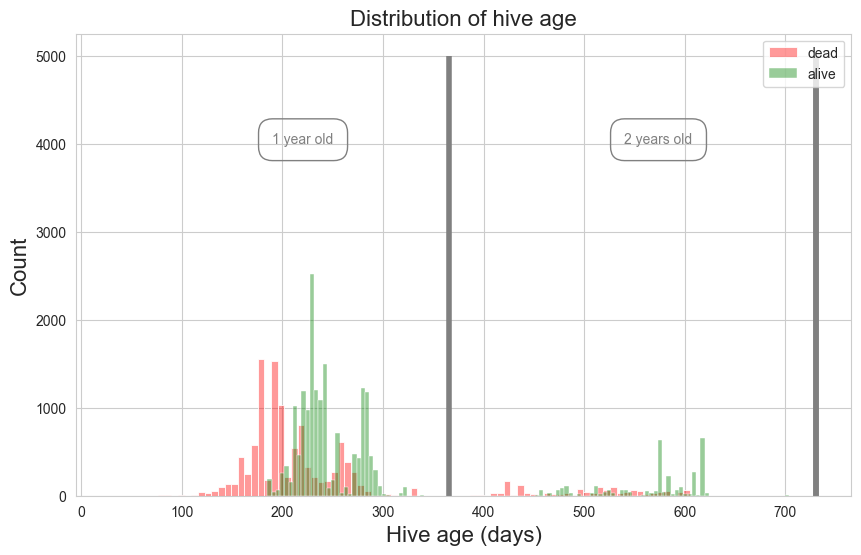

In [136]:
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
p = sns.histplot(data.loc[data['death_next_season']]['hive_age_next_season'] -150, ax=ax, color="red", alpha=0.4, label="dead")
p = sns.histplot(data.loc[~data['death_next_season']]['hive_age_next_season'] - 150, ax=ax, color="green", alpha=0.4,label="alive")
p.set_xlabel("Hive age (days)", size=16)
p.set_ylabel("Count", size=16)
p.set_title("Distribution of hive age",size=16)
plt.vlines(365.25,0,5000, color="grey", linewidth=4)
plt.vlines(365.25*2,0,5000, color="grey", linewidth=4)
plt.vlines(365.25*2,0,5000, color="grey",linewidth=4)
plt.legend()
ax.text(190, 4000, '1 year old', color='grey', 
        bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))
ax.text(540, 4000, '2 years old', color='grey', 
        bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))

plt.savefig("hive_age_distribution.png")

### Add region

In [53]:
if RUN_PREPROCESS:
    operation_meta.index = operation_meta['Operation ID']
    regions = operation_meta.to_dict(orient="dict")['Location']

In [54]:
def try_region(x):
    try:
        return regions[str(x)].split(",")[1]
    except:
        return 'Unknown'

In [55]:
if RUN_PREPROCESS:
    data['region'] = data['operation_id'].apply(lambda x: try_region(x))
data.groupby(['operation_id','season']).count()

hid  creation_date  death_date  death_next_season  \
operation_id season                                                        
36           2021      327            327         327                327   
             2022      384            384         384                384   
             2023      373            373         373                373   
55           2021     5094           5094        5094               5094   
             2022     4514           4514        4514               4514   
             2023     5005           5005        5005               5005   
69           2021     2547           2547        2547               2547   
             2022    11924          11924       11924              11924   
             2023    18516          18516       18516              18516   
83           2021       20             20          20                 20   
             2022      114            114         114                114   
             2023       54             54          54                 54   
87           2022     1892           1892        1892               1892   
             2023     2697           2697        2697               2697   
153          2022     8745           8745        8745               8745   
             2023     9523           9523        9523               9523   
159          2022      115            115         115                115   
             2023      112            112         112                112   
160          2022      145            145         145                145   
             2023      262            262         262                262   
161          2022     3098           3098        3098               3098   
             2023     4972           4972        4972               4972   
167          2023     9544           9544        9544               9544   
193          2023    44495          44495       44495              44495   
194          2023      973            973         973                973   
195          2023     1591           1591        1591               1591   
199          2023        2              2           2                  2   
205          2023      193            193         193                193   
207          2023     5822           5822        5822               5822   
210          2023     1828           1828        1828               1828   
212          2023      758            758         758                758   
219          2023      397            397         397                397   
220          2023      631            631         631                631   
224          2023      251            251         251                251   

                     hive_age_next_season  aqhi_average  prcp_average  \
operation_id season                                                     
36           2021                     327           327           327   
             2022                     384           373           373   
             2023                     373           373           373   
55           2021                    5094          4154          4154   
             2022                    4514          4457          4457   
             2023                    5005          4724          4724   
69           2021                    2547          2547          2547   
             2022                   11924         11916         11916   
             2023                   18516         18411         18411   
83           2021                      20            20            20   
             2022                     114           112           112   
             2023                      54            53            53   
87           2022                    1892          1698          1698   
             2023                    2697          2351          2351   
153          2022                    8745          8730          8730   
             2023                    9523    

### Saving preprocess so we don't need to run every time

In [56]:
if RUN_PREPROCESS:
    data.to_csv(os.path.join(ROOT_PATH,"preprocess.csv"),index=False)
else:
    data = pd.read_csv(os.path.join(ROOT_PATH,"preprocess.csv"))

In [57]:
len(data)

146918

In [58]:
ONLY_WINTER = False
ONLY_INSEASON = False 
ACTIVE_ALL_AND_WINTER = True  # Blog post hypothesis 
if ONLY_WINTER or ONLY_INSEASON:
    assert ONLY_WINTER != ONLY_INSEASON, "choose one! or both False"
if ONLY_INSEASON or ACTIVE_ALL_AND_WINTER:
    assert ACTIVE_ALL_AND_WINTER != ONLY_INSEASON, "choose one! or both False"

# Reload and apply
data = pd.read_csv(os.path.join(ROOT_PATH,"preprocess.csv"))

In [59]:
len(data)

146918

In [60]:
if ONLY_WINTER:
    # Exclude in-season deadout , we are just looking at winter morta 
    data['death_date'] = pd.to_datetime(data['death_date']).dt.date
    data['winter_deadout'] = data.apply(lambda x: x['death_date'] > date(int(x['season']),END_SEASON_MONTH,END_SEASON_DAY),axis=1)
    data = data.loc[data['winter_deadout']].reset_index(drop=True)

if ONLY_INSEASON:
    data['death_date'] = pd.to_datetime(data['death_date']).dt.date
    data['winter_deadout'] = data.apply(lambda x: x['death_date'].month in [6,7,8],axis=1)
    data = data.loc[~data['winter_deadout'] | ~data['death_next_season']].reset_index(drop=True)

if ACTIVE_ALL_AND_WINTER:
    data['death_date'] = pd.to_datetime(data['death_date']).dt.date
    data['creation_date'] = pd.to_datetime(data['creation_date']).dt.date
    # This ensure the exposition rate is the full season (makes them comparable with the current approach)
    data = data.loc[(data['creation_date'] <= data['season'].apply(lambda x: date(int(x),START_SEASON_MONTH+1,START_SEASON_DAY))) \
            & (data['death_date'] > data['season'].apply(lambda x : date(int(x),END_SEASON_MONTH,END_SEASON_DAY)))]
    data = data.reset_index(drop=True)


### Keep next year aside and exclude some abnormal data

In [61]:
next_year = data.loc[data['season']==2023].reset_index(drop=True)
if not ONLY_INSEASON:
    data = data.loc[data['season']!=2023].reset_index(drop=True)

In [62]:
len(data)

31282

In [63]:
data.groupby(["death_next_season","season"]).mean(numeric_only=True)

hid  operation_id  hive_age_next_season  \
death_next_season season                                                     
False             2021    17214.810992     58.976765            380.880250   
                  2022    54338.229713     98.331467            453.505137   
True              2021    16967.646795     60.143677            346.812671   
                  2022    52390.380075    106.675444            412.711376   

                          aqhi_average  prcp_average  wspd_average  \
death_next_season season                                             
False             2021        3.309626      1.876931     10.864410   
                  2022        3.019967      2.650974     11.763491   
True              2021        3.292246      1.875566     11.004013   
                  2022        3.035775      2.488541     11.349841   

                          ndvi_average  tavg_average  o3_average  aqhi_skew  \
death_next_season season                                                      
False             2021        0.265284     18.667193   51.528034   0.895326   
                  2022        0.359913     17.015027   49.434432   0.478409   
True              2021        0.268980     18.607454   51.081909   0.879528   
                  2022        0.363580     16.835221   50.372577   0.429254   

                          ...  wspd_skew  ndvi_skew  tavg_skew   o3_skew  \
death_next_season season  ...                                              
False             2021    ...   0.901388  -0.656164  -0.233838  0.613022   
                  2022    ...   1.240194   0.127969  -0.327350  0.449161   
True              2021    ...   0.888531  -0.672334  -0.260736  0.638123   
                  2022    ...   1.301781   0.051286  -0.345438  0.399424   

                          aqhi_max   prcp_max   wspd_max  ndvi_max   tavg_max  \
death_next_season season                                                        
False             2021    6.687790  32.192315  24.418901  0.621085  27.022252   
                  2022    5.293808  39.709015  29.482137  0.673327  24.157105   
True              2021    6.618762  33.060863  24.280993  0.625588  26.843402   
                  2022    5.274640  40.602841  30.011000  0.668981  24.252147   

                             o3_max  
death_next_season season             
False             2021    98.834905  
                  2022    86.404779  
True              2021    99.062302  
                  2022    86.820124  

[4 rows x 21 columns]

In [64]:
data.season.value_counts()

season
2022    25035
2021     6247
Name: count, dtype: int64

In [65]:
data.isnull().mean()

hid                     0.000000
creation_date           0.000000
operation_id            0.000000
death_date              0.000000
season                  0.000000
death_next_season       0.000000
hive_age_next_season    0.000000
aqhi_average            0.000000
prcp_average            0.000000
wspd_average            0.000000
ndvi_average            0.000000
tavg_average            0.000000
o3_average              0.000000
aqhi_skew               0.000000
prcp_skew               0.002206
wspd_skew               0.000000
ndvi_skew               0.004891
tavg_skew               0.000000
o3_skew                 0.000000
aqhi_max                0.000000
prcp_max                0.000000
wspd_max                0.000000
ndvi_max                0.000000
tavg_max                0.000000
o3_max                  0.000000
region                  0.000000
dtype: float64

*** 
### Quick viz 

Just checking a bit the data for intuition

### Check different sensors bar chart

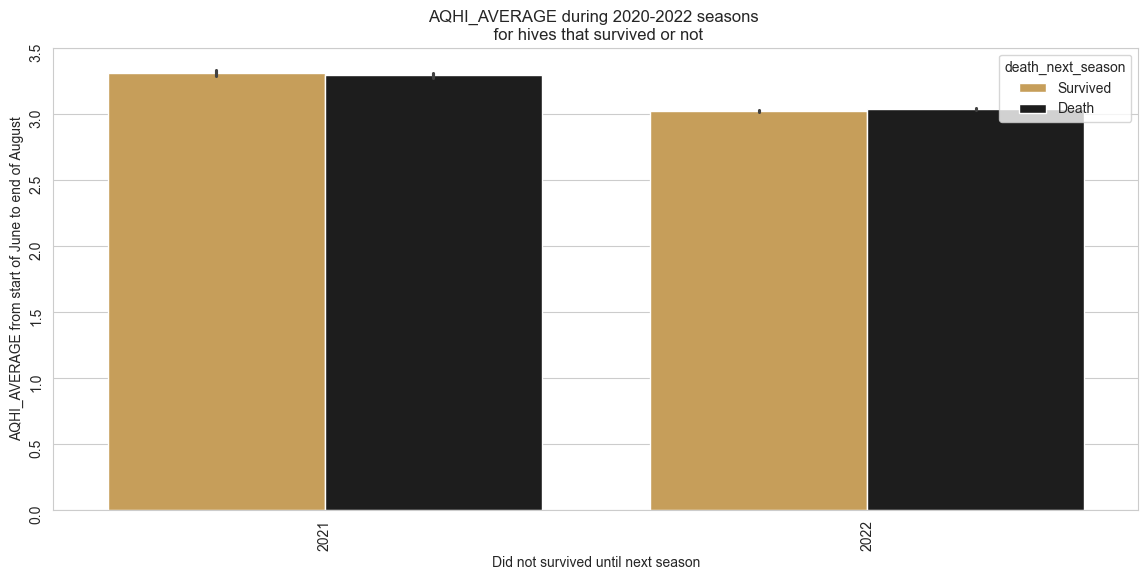

In [66]:
plot_survival_bar_per_state(data, "aqhi_average") # Bias by region for sure

### Check relation NDVI ~ AQHI


Idea is that increased vegetation should lead to less extreme AQHI value

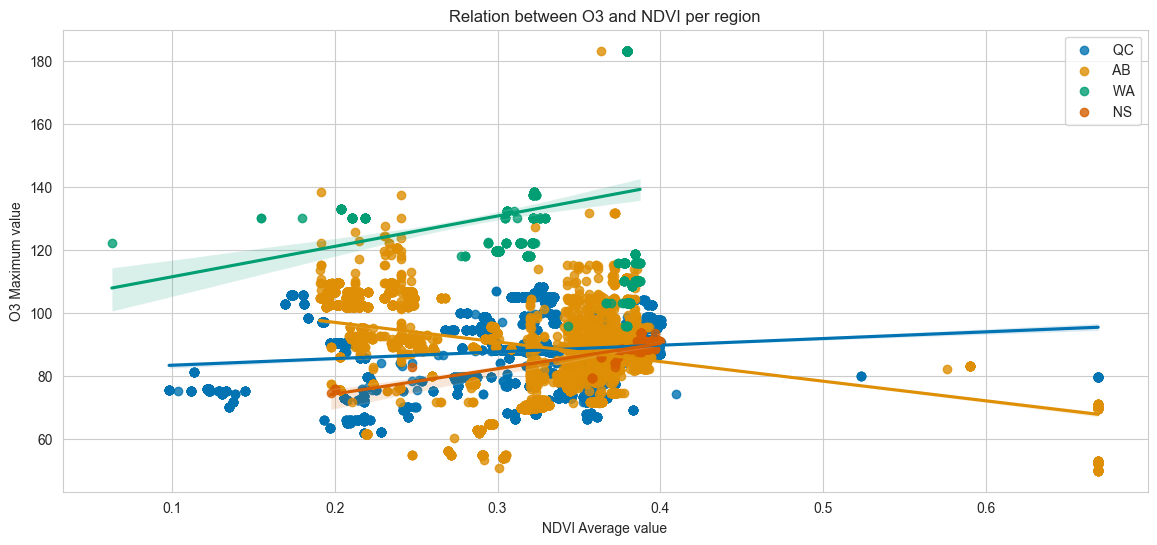

In [67]:
sns.set_palette('colorblind') # Otherwise very confusing 
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
for s in data['region'].unique():
    sub = data.loc[data['region']==s]
    if len(sub) > 10:
        sns.regplot(x=sub["ndvi_average"], y=sub["o3_max"], label=s, ax=ax)
plt.ylabel("O3 Maximum value")
plt.xlabel("NDVI Average value")
plt.title("Relation between O3 and NDVI per region")
plt.legend()
plt.show()

<Axes: xlabel='ndvi_average', ylabel='aqhi_max'>

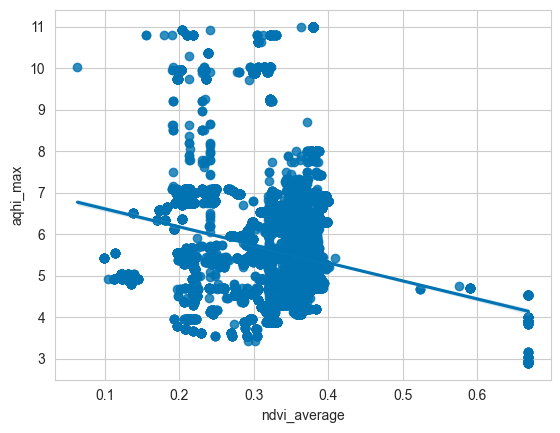

In [68]:
sns.regplot(x=data["ndvi_average"], y=data["aqhi_max"])

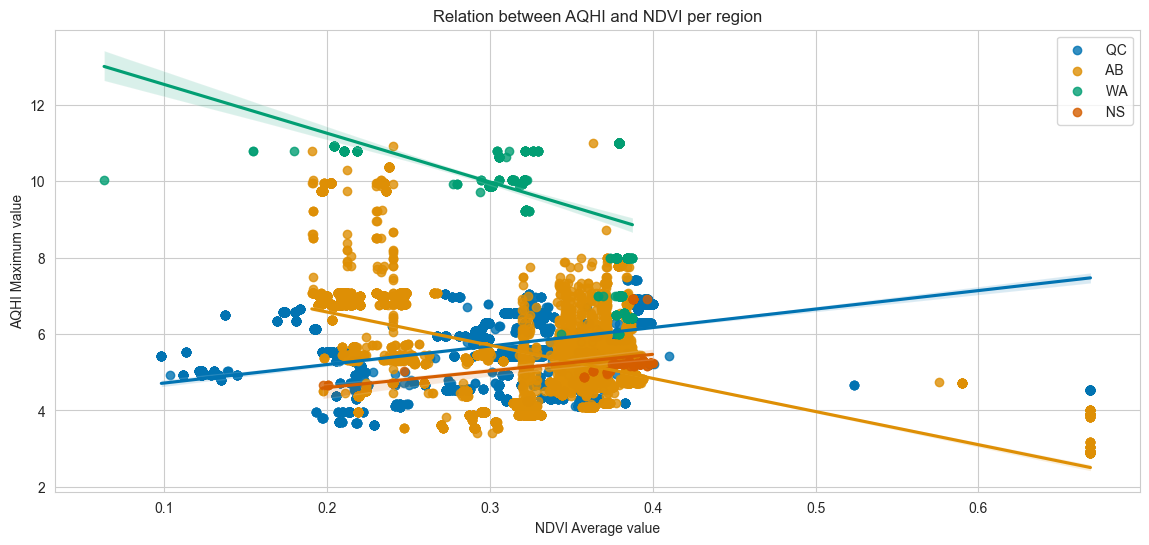

In [69]:
sns.set_palette('colorblind') # Otherwise very confusing 
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
for s in data['region'].unique():
    sub = data.loc[data['region']==s]
    if len(sub) > 10:
        sns.regplot(x=sub["ndvi_average"], y=sub["aqhi_max"], label=s, ax=ax)
plt.ylabel("AQHI Maximum value")
plt.xlabel("NDVI Average value")
plt.title("Relation between AQHI and NDVI per region")
plt.legend()
plt.show()

### Check raw AQHI ~ mortality

Pattern for Quebec are different from the rest of the dataset

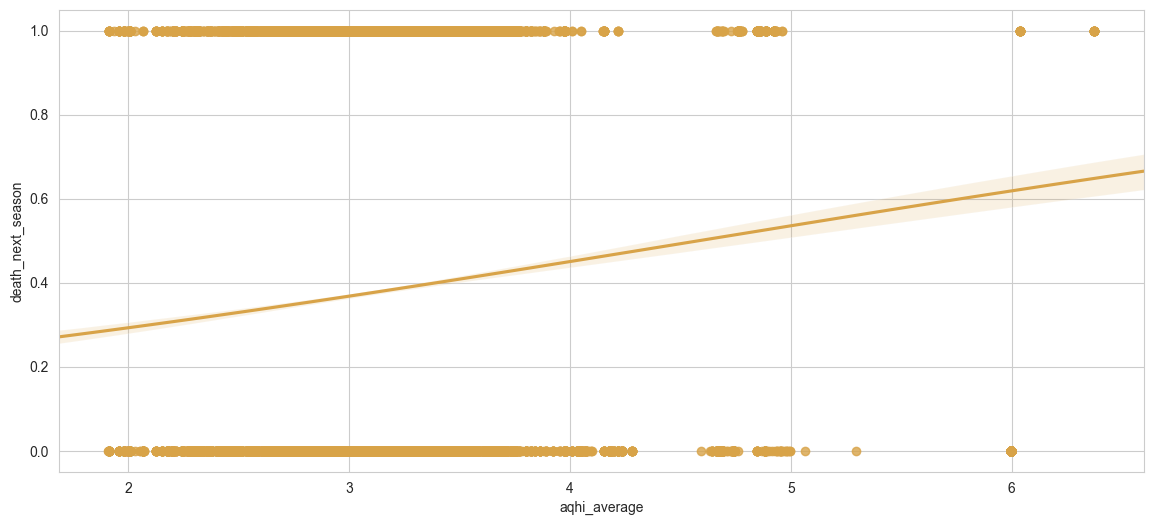

In [70]:
sns.set_palette(NECTAR_PALETTE)
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
sns.regplot(x="aqhi_average",y="death_next_season",data=data,logistic=True, truncate=False, ax=ax)
plt.show()

# This is starnge and may be due to hive located norther have faced more heavy aqhi ?

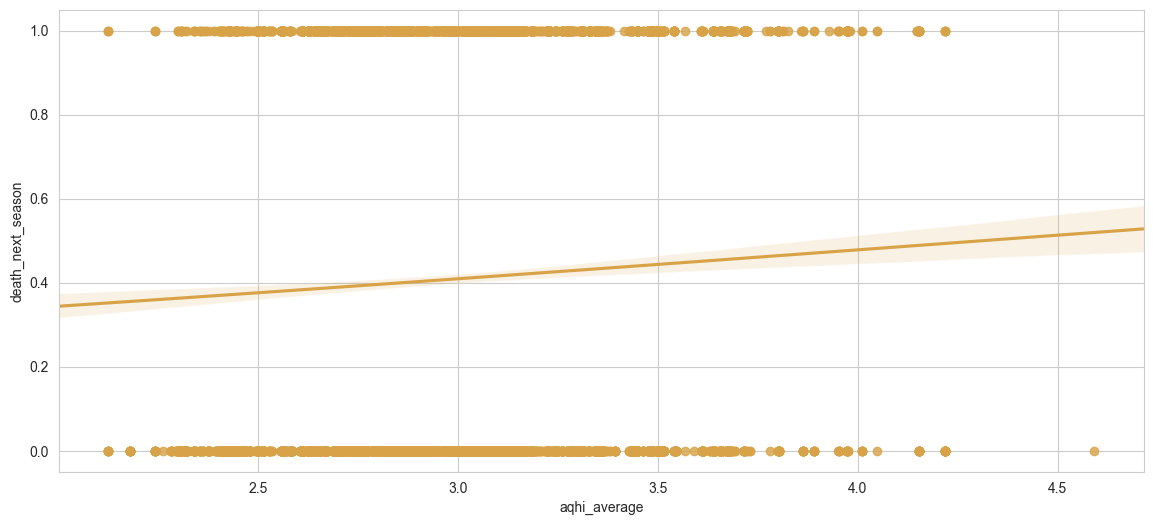

In [71]:
sns.set_palette(NECTAR_PALETTE)
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
sns.regplot(x="aqhi_average",y="death_next_season",data=data.loc[data['region']==" QC"],logistic=True, truncate=False, ax=ax)
plt.show()

# This is starnge and may be due to hive located norther have faced more heavy aqhi ?

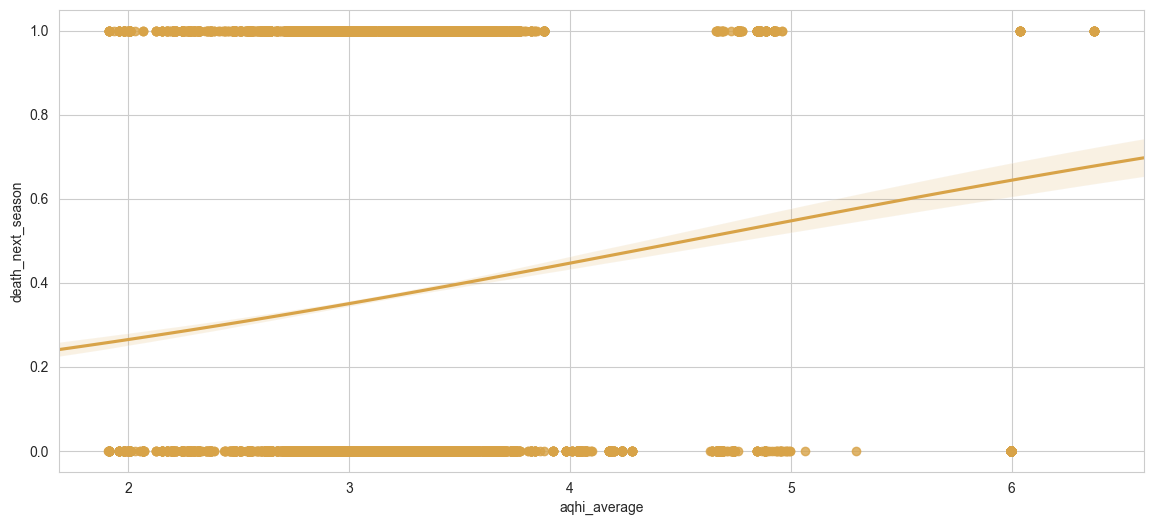

In [72]:
sns.set_palette(NECTAR_PALETTE)
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
sns.regplot(x="aqhi_average",y="death_next_season",data=data.loc[data['region']!=" QC"],logistic=True, truncate=False, ax=ax)
plt.show()

*** 
### Check per region

In [73]:
data.region.value_counts()

region
 AB    21850
 QC     8668
 WA      673
 NS       91
Name: count, dtype: int64

In [74]:
data.groupby("region").mean(numeric_only=True)

,hid,operation_id,season,death_next_season,hive_age_next_season,aqhi_average,prcp_average,wspd_average,ndvi_average,tavg_average,...,wspd_skew,ndvi_skew,tavg_skew,o3_skew,aqhi_max,prcp_max,wspd_max,ndvi_max,tavg_max,o3_max
region,,,,,,,,,,,,,,,,,,,,,
AB,52321.428696,101.198993,2021.883432,0.366819,404.162609,3.067810,2.136049,11.965161,0.344971,16.795063,...,1.381176,0.047212,-0.303457,0.438336,5.318809,38.638723,31.193039,0.660653,24.354435,87.905609
NS,58276.054945,160.000000,2022.000000,0.219780,391.956044,3.281968,2.721121,10.075367,0.376632,16.184050,...,0.674777,0.027579,-0.487913,0.317497,5.367582,40.708791,18.845055,0.732820,23.907692,88.333797
QC,33055.118482,74.892940,2021.610406,0.406784,470.531841,2.963611,3.414697,10.385652,0.335940,18.221288,...,0.716248,-0.266856,-0.346072,0.530157,5.858942,40.039455,22.345639,0.667898,25.143932,88.318580
WA,25027.557207,36.000000,2021.520059,0.233284,500.167905,4.923337,0.469188,10.938107,0.337200,21.653113,...,0.971654,-0.443355,-0.339644,0.876040,9.502043,15.706538,25.526746,0.638811,31.692719,134.260672


In [75]:
# data = data.loc[data['region']!=' CA']
data.region.value_counts()

region
 AB    21850
 QC     8668
 WA      673
 NS       91
Name: count, dtype: int64

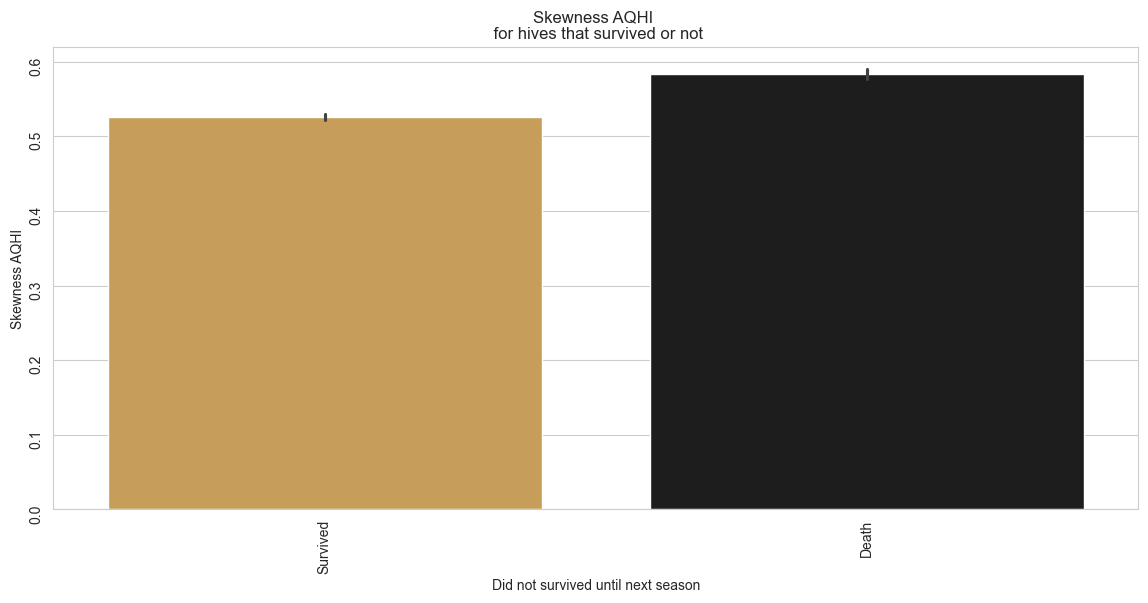

In [76]:
sns.set_style("whitegrid")
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
ax = sns.barplot(
    y=data['aqhi_skew'],x=data["death_next_season"].apply(lambda x : "Death" if x == 1 else "Survived"), ax=axes,
    palette="blend:#D8A348,#1D1D1D"#, errcolor="darkred"
)
#  
ax.set_ylabel("Skewness AQHI")
ax.set_xlabel("Did not survived until next season")
ax.tick_params(labelrotation=90)
plt.title("Skewness AQHI \n for hives that survived or not")
plt.show()

***
### DESCRIPTIVE STATS

In [77]:
data[['aqhi_average','ndvi_average']].isnull().mean()

aqhi_average    0.0
ndvi_average    0.0
dtype: float64

In [78]:
data.dropna(subset=['aqhi_average','ndvi_average'],axis=0,inplace=True) # Filling null value with zero

data['operation_id'] = data['operation_id'].astype(str)
data['season'] = data['season'].astype(str)

In [79]:
len(data)

31282

### Models 

In [80]:
data['wspd_average_og'] = data['wspd_average']
data['tavg_average_og'] = data['tavg_average']
data['prcp_average_og'] = data['prcp_average']
data['aqhi_average_og'] = data['aqhi_average']

data['wspd_average'] = np.log(data['wspd_average']+10e-5)
data['tavg_average'] = np.log(data['tavg_average']+10e-5)
data['prcp_average'] = np.log(data['prcp_average']+10e-5)
data['aqhi_average'] = np.log(data['aqhi_average']+10e-5)

<Axes: xlabel='aqhi_max', ylabel='Count'>

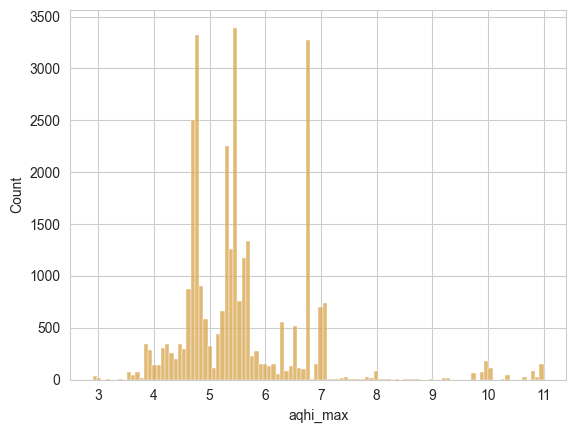

In [81]:
sns.histplot(data['aqhi_max'])

<Axes: xlabel='aqhi_average', ylabel='Count'>

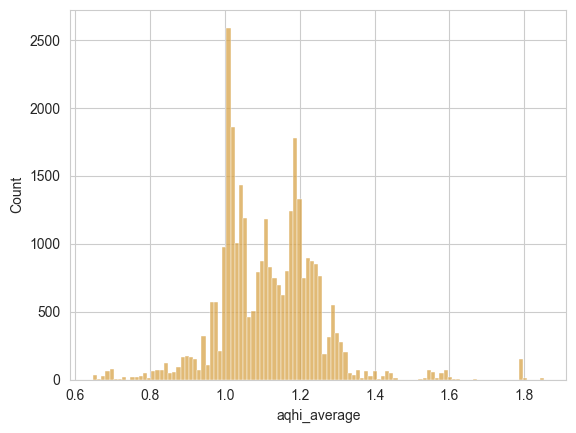

In [82]:
sns.histplot(data['aqhi_average'])

<Axes: xlabel='ndvi_average', ylabel='Count'>

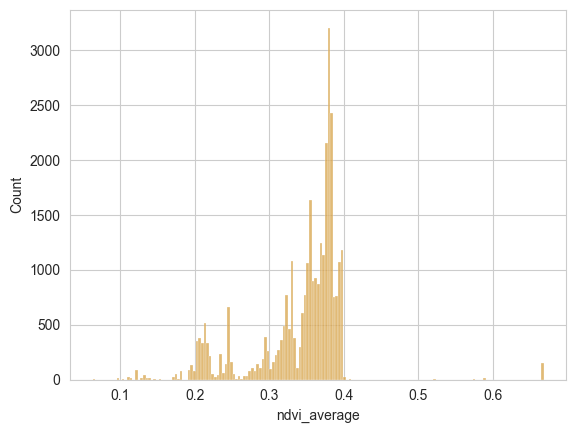

In [83]:
sns.histplot(data['ndvi_average'])

<Axes: xlabel='wspd_average', ylabel='Count'>

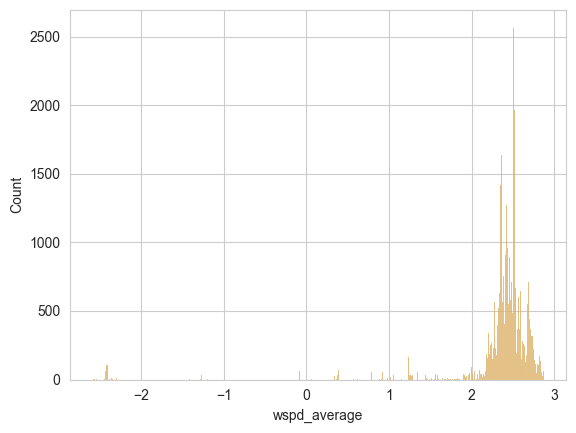

In [84]:
sns.histplot(data['wspd_average'])

In [85]:
data.death_next_season.mean()

0.3745924173646186

In [86]:
data.isnull().mean()

hid                     0.000000
creation_date           0.000000
operation_id            0.000000
death_date              0.000000
season                  0.000000
death_next_season       0.000000
hive_age_next_season    0.000000
aqhi_average            0.000000
prcp_average            0.000000
wspd_average            0.000000
ndvi_average            0.000000
tavg_average            0.000000
o3_average              0.000000
aqhi_skew               0.000000
prcp_skew               0.002206
wspd_skew               0.000000
ndvi_skew               0.004891
tavg_skew               0.000000
o3_skew                 0.000000
aqhi_max                0.000000
prcp_max                0.000000
wspd_max                0.000000
ndvi_max                0.000000
tavg_max                0.000000
o3_max                  0.000000
region                  0.000000
wspd_average_og         0.000000
tavg_average_og         0.000000
prcp_average_og         0.000000
aqhi_average_og         0.000000
dtype: flo

In [87]:
model0 = Lmer("death_next_season  ~ 1 + (1|region)",
             data=data, family = 'binomial')

print(model0.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~1+(1|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -20640.993 	 AIC: 41285.987

Random effects:

               Name    Var    Std
region  (Intercept)  0.134  0.366

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -0.806  -1.173   -0.439  0.187  0.447      0.309       0.645   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.309        0.236         0.392    -4.3    0.0  ***  


In [88]:
model = Lmer("death_next_season  ~  aqhi_average*ndvi_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -20054.252 	 AIC: 40122.505

Random effects:

                Name    Var    Std
region   (Intercept)  2.589  1.609
region  aqhi_average  0.612  0.783

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.911

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE           OR  \
(Intercept)                  -8.819 -10.776   -6.863  0.998        0.000   
aqhi_average                  7.815   6.562    9.069  0.639     2478.383   
ndvi_average                 16.090  13.041   19.139  1.556  9723142.436   
aqhi_average:ndvi_average   -17.258 -19.864  -14.651  1.330        0.000   

                            OR_2.5_ci    OR_97.5_ci  Prob  Prob_2.5_ci  \
(Intercept)                     0.000  1.000000

In [89]:
model2 = Lmer("death_next_season  ~ aqhi_average + ndvi_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model2.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average+ndvi_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -20111.452 	 AIC: 40234.904

Random effects:

                Name    Var    Std
region   (Intercept)  0.867  0.931
region  aqhi_average  0.302  0.550

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.666

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     -1.818  -3.049   -0.586  0.628  0.162      0.047       0.556   
aqhi_average     1.916   1.118    2.713  0.407  6.792      3.060      15.077   
ndvi_average    -4.036  -4.426   -3.646  0.199  0.018      0.012       0.026   

               Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)   0.140        0.045         0.357  -2.893  0.004   **  
aqhi_average  0.872        0.754         0.

In [90]:
model3 = Lmer("death_next_season  ~ aqhi_average*ndvi_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model3.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -20054.252 	 AIC: 40122.505

Random effects:

                Name    Var    Std
region   (Intercept)  2.589  1.609
region  aqhi_average  0.612  0.783

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.911

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE           OR  \
(Intercept)                  -8.819 -10.776   -6.863  0.998        0.000   
aqhi_average                  7.815   6.562    9.069  0.639     2478.383   
ndvi_average                 16.090  13.041   19.139  1.556  9723142.436   
aqhi_average:ndvi_average   -17.258 -19.864  -14.651  1.330        0.000   

                            OR_2.5_ci    OR_97.5_ci  Prob  Prob_2.5_ci  \
(Intercept)                     0.000  1.000000

In [91]:
model4 = Lmer("death_next_season  ~ aqhi_average + ndvi_average + tavg_average + prcp_average + wspd_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model4.fit())

Model failed to converge with max|grad| = 0.0064893 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average+ndvi_average+tavg_average+prcp_average+wspd_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -19915.155 	 AIC: 39848.310

Random effects:

                Name    Var    Std
region   (Intercept)  5.866  2.422
region  aqhi_average  5.437  2.332

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.994

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE        OR  OR_2.5_ci  \
(Intercept)      7.464   3.708   11.219  1.916  1743.420     40.787   
aqhi_average    -0.285  -3.267    2.697  1.521     0.752      0.038   
ndvi_average    -5.390  -6.040   -4.740  0.332     0.005      0.002   
tavg_average    -1.775  -2.362   -1.188  0.300     0.169      0.094   
prcp_average    -0.426  -0.

In [92]:
model5 = Lmer("death_next_season  ~ aqhi_average*wspd_average + ndvi_average + tavg_average + prcp_average   + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model5.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*wspd_average+ndvi_average+tavg_average+prcp_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -19910.301 	 AIC: 39840.602

Random effects:

                Name    Var    Std
region   (Intercept)  3.273  1.809
region  aqhi_average  3.582  1.893

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.989

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE      OR  \
(Intercept)                   2.454  -0.713    5.620  1.615  11.629   
aqhi_average                  3.737   1.177    6.297  1.306  41.975   
wspd_average                  1.522   0.593    2.451  0.474   4.583   
ndvi_average                 -5.311  -5.932   -4.690  0.317   0.005   
tavg_average                 -1.720  -2.270   -1.169  0.281   0.179   
prcp_average                 -0.415  

In [93]:
model6 = Lmer("death_next_season  ~ aqhi_average*wspd_average*tavg_average + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model6.fit())

Model failed to converge with max|grad| = 0.0228665 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*wspd_average*tavg_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -20109.402 	 AIC: 40240.803

Random effects:

                Name    Var    Std
region   (Intercept)  7.724  2.779
region  aqhi_average  2.497  1.580

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.892

Fixed effects:

                                        Estimate   2.5_ci  97.5_ci     SE  \
(Intercept)                              260.937  255.969  265.905  2.535   
aqhi_average                            -233.103 -237.238 -228.968  2.110   
wspd_average                            -101.027 -104.801  -97.252  1.926   
tavg_average                             -93.529  -95.508  -91.550  1.010   
aqhi_average:wspd_avera

In [94]:
model7a = Lmer("death_next_season  ~ aqhi_average*ndvi_average*wspd_average  + (ndvi_average|region) ",
             data=data, family = 'binomial')

print(model7a.fit())

Model failed to converge with max|grad| = 0.00401148 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average*wspd_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -19969.377 	 AIC: 39960.754

Random effects:

                Name     Var    Std
region   (Intercept)   0.974  0.987
region  ndvi_average  19.896  4.461

                IV1           IV2   Corr
region  (Intercept)  ndvi_average -0.939

Fixed effects:

                                        Estimate   2.5_ci  97.5_ci     SE  \
(Intercept)                               48.067   45.039   51.095  1.545   
aqhi_average                             -46.009  -48.844  -43.174  1.447   
ndvi_average                            -141.786 -147.770 -135.803  3.053   
wspd_average                             -23.285  -24.651  -21.919  0.697   
aqhi_average:ndvi_a

In [95]:
model7 = Lmer("death_next_season  ~ aqhi_average*ndvi_average + wspd_average + (ndvi_average|region)",
             data=data, family = 'binomial')

print(model7.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average+wspd_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -20004.441 	 AIC: 40024.883

Random effects:

                Name    Var    Std
region   (Intercept)  0.751  0.866
region  ndvi_average  1.550  1.245

                IV1           IV2   Corr
region  (Intercept)  ndvi_average -0.479

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE            OR  \
(Intercept)                  -9.194 -11.042   -7.347  0.943  0.000000e+00   
aqhi_average                  8.817   7.568   10.067  0.637  6.750726e+03   
ndvi_average                 18.839  13.775   23.902  2.583  1.518673e+08   
wspd_average                 -0.192  -0.231   -0.153  0.020  8.250000e-01   
aqhi_average:ndvi_average   -20.245 -24.003  -16.487  1.917  0.000000e+00   

                          

In [96]:
model8 = Lmer("death_next_season  ~ aqhi_average*ndvi_average*wspd_average + (aqhi_average|region) ",
             data=data, family = 'binomial')

print(model8.fit())

Model failed to converge with max|grad| = 0.00352719 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average*wspd_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -19981.970 	 AIC: 39985.941

Random effects:

                Name    Var    Std
region   (Intercept)  7.360  2.713
region  aqhi_average  2.055  1.434

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.986

Fixed effects:

                                        Estimate   2.5_ci  97.5_ci     SE  \
(Intercept)                               30.817   27.130   34.505  1.881   
aqhi_average                             -28.804  -31.628  -25.979  1.441   
ndvi_average                            -114.007 -119.495 -108.520  2.800   
wspd_average                             -16.878  -18.219  -15.537  0.684   
aqhi_average:ndvi_aver

In [97]:
model9 = Lmer("death_next_season  ~ aqhi_skew*ndvi_average*wspd_average + (aqhi_skew|region) ",
             data=data, family = 'binomial')
print(model9.fit())

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_skew*ndvi_average*wspd_average+(aqhi_skew|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -19903.403 	 AIC: 39828.806

Random effects:

               Name    Var    Std
region  (Intercept)  0.333  0.577
region    aqhi_skew  0.710  0.842

                IV1        IV2  Corr
region  (Intercept)  aqhi_skew -0.61

Fixed effects:

                                     Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                            -1.785  -5.643    2.073  1.968   
aqhi_skew                              -2.446  -8.055    3.163  2.862   
ndvi_average                            3.118  -7.163   13.400  5.246   
wspd_average                           -0.296  -1.861    1.270  0.799   
aqhi_skew:ndvi_average      

In [98]:
model10 = Lmer("death_next_season  ~ aqhi_skew*ndvi_skew  + (aqhi_skew|region) ",
             data=data, family = 'binomial')

print(model10.fit())

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_skew*ndvi_skew+(aqhi_skew|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -19299.198 	 AIC: 38612.395

Random effects:

               Name    Var    Std
region  (Intercept)  0.344  0.587
region    aqhi_skew  0.095  0.309

                IV1        IV2  Corr
region  (Intercept)  aqhi_skew  0.44

Fixed effects:

                     Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)            -1.191  -1.807   -0.575  0.314  0.304      0.164   
aqhi_skew              -0.045  -0.431    0.341  0.197  0.956      0.650   
ndvi_skew   

In [99]:
model11 = Lmer("death_next_season  ~ aqhi_skew*ndvi_average + wspd_average  + (aqhi_skew|region) ",
             data=data, family = 'binomial')

print(model11.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_skew*ndvi_average+wspd_average+(aqhi_skew|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -19926.045 	 AIC: 39868.089

Random effects:

               Name    Var    Std
region  (Intercept)  0.283  0.532
region    aqhi_skew  0.691  0.831

                IV1        IV2   Corr
region  (Intercept)  aqhi_skew -0.561

Fixed effects:

                        Estimate  2.5_ci  97.5_ci     SE       OR  OR_2.5_ci  \
(Intercept)               -2.016  -2.676   -1.357  0.336    0.133      0.069   
aqhi_skew                  5.035   4.030    6.039  0.513  153.649     56.253   
ndvi_average               3.278   2.434    4.122  0.431   26.513     11.400   
wspd_average              -0.214  -0.254   -0.175  0.020    0.807      0.776   
aqhi_skew:ndvi_average   -12.994 -14.170  -11.818  0.600    0.000      0.000   

                       

In [100]:
model12 = Lmer("death_next_season  ~ aqhi_max*ndvi_average + wspd_average  + (ndvi_average|region)",
             data=data, family = 'binomial')

print(model12.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_max*ndvi_average+wspd_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -19919.960 	 AIC: 39855.920

Random effects:

                Name    Var    Std
region   (Intercept)  1.465  1.210
region  ndvi_average  3.265  1.807

                IV1           IV2   Corr
region  (Intercept)  ndvi_average -0.707

Fixed effects:

                       Estimate  2.5_ci  97.5_ci     SE       OR  OR_2.5_ci  \
(Intercept)              -4.659  -6.029   -3.289  0.699    0.009      0.002   
aqhi_max                  0.902   0.803    1.001  0.051    2.465      2.232   
ndvi_average              6.629   3.803    9.455  1.442  756.803     44.841   
wspd_average             -0.208  -0.247   -0.169  0.020    0.812      0.781   
aqhi_max:ndvi_average    -1.752  -2.059   -1.445  0.157    0.173      0.128   

                  

In [101]:
model13 = Lmer("death_next_season  ~ aqhi_average*wspd_average + ndvi_average  + (ndvi_average|region)",
             data=data, family = 'binomial')

print(model13.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*wspd_average+ndvi_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -20055.479 	 AIC: 40126.958

Random effects:

                Name     Var    Std
region   (Intercept)   0.175  0.419
region  ndvi_average  12.141  3.484

                IV1           IV2  Corr
region  (Intercept)  ndvi_average -0.91

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE      OR  \
(Intercept)                  -3.039  -5.432   -0.646  1.221   0.048   
aqhi_average                  4.177   2.234    6.121  0.991  65.193   
wspd_average                  0.744  -0.172    1.661  0.468   2.105   
ndvi_average                 -7.055 -10.273   -3.837  1.642   0.001   
aqhi_average:wspd_average    -0.795  -1.576   -0.014  0.398   0.451   

                           OR_2.5_ci  OR_97.5_ci   Prob  Prob

In [102]:
model14 = Lmer("death_next_season  ~ aqhi_max*ndvi_average*wspd_average  + (ndvi_average|region) ",
             data=data, family = 'binomial')

print(model14.fit())

[1] "Model failed to converge with max|grad| = 0.00221455 (tol = 0.002, component 1)"
[2] " \n"                                                                            

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_max*ndvi_average*wspd_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -19881.682 	 AIC: 39785.363

Random effects:

                Name     Var    Std
region   (Intercept)   1.105  1.051
region  ndvi_average  24.820  4.982

                IV1           IV2   Corr
region  (Intercept)  ndvi_average -0.942

Fixed effects:

                                    Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                           26.023  23.416   28.630  1.330   
aqhi

In [103]:
model15 = Lmer("death_next_season  ~ aqhi_average*ndvi_skew*wspd_average + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model15.fit())

boundary (singular) fit: see help('isSingular') 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_skew*wspd_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -19263.573 	 AIC: 38549.145

Random effects:

                Name    Var    Std
region   (Intercept)  4.096  2.024
region  aqhi_average  0.627  0.792

                IV1           IV2  Corr
region  (Intercept)  aqhi_average  -1.0

Fixed effects:

                                     Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                            -0.458  -3.349    2.433  1.475   
aqhi_average 

In [104]:
model16 = Lmer("death_next_season  ~ aqhi_average*ndvi_skew + wspd_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model16.fit())

boundary (singular) fit: see help('isSingular') 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_skew+wspd_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -19293.849 	 AIC: 38603.699

Random effects:

                Name    Var    Std
region   (Intercept)  5.341  2.311
region  aqhi_average  0.869  0.932

                IV1           IV2  Corr
region  (Intercept)  aqhi_average  -1.0

Fixed effects:

                        Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)               -2.094  -4.335    0.148  1.144  0.123      0.013   
aqh

In [105]:
model17 = Lmer("death_next_season  ~ aqhi_average*ndvi_skew*wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model17.fit())

Model failed to converge with max|grad| = 0.00669806 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_skew*wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -18736.132 	 AIC: 37494.264

Random effects:

                      Name     Var    Std
operation_id   (Intercept)  35.916  5.993
operation_id  aqhi_average  31.746  5.634

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.975

Fixed effects:

                                     Estimate  2.5_ci  97.5_ci     SE  \
(Interc

In [106]:
model18 = Lmer("death_next_season  ~ aqhi_max*ndvi_average + aqhi_average*wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model18.fit())

Model failed to converge with max|grad| = 0.002437 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_max*ndvi_average+aqhi_average*wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19137.712 	 AIC: 38295.424

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  3.825  1.956
operation_id  aqhi_average  4.059  2.015

                      IV1           IV2  Corr
operation_id  (Intercept)  aqhi_average -0.86

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE         OR  \
(Intercept)                   1.284  -1.421    3.988  1.380      3.610   
aqhi_max                      0.745   0.629    0.862  0.060      2.107   
ndvi_average                  9.461   7.628   11.294  0.935  12851.851   
aqhi_average                 -3.531  -5.960   -1.101  1.239     

In [107]:
model19 = Lmer("death_next_season  ~ ndvi_average*aqhi_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model19.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19255.985 	 AIC: 38525.971

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  5.096  2.258
operation_id  aqhi_average  5.439  2.332

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.888

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE          OR  \
(Intercept)                  -7.504  -9.472   -5.535  1.004       0.001   
ndvi_average                 12.485   9.146   15.825  1.704  264428.642   
aqhi_average                  7.295   5.442    9.148  0.946    1472.742   
ndvi_average:aqhi_average   -14.616 -17.551  -11.682  1.497       0.000   

                           OR_2.5_ci   OR_97.5_ci   Prob  Prob_2.5_ci  \
(Intercept)

In [108]:
model20 = Lmer("death_next_season  ~ ndvi_average*aqhi_average*wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model20.fit())

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average*wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19187.718 	 AIC: 38397.437

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  4.849  2.202
operation_id  aqhi_average  5.034  2.244

                      IV1           IV2  Corr
operation_id  (Intercept)  aqhi_average -0.89

Fixed effects:

                                        Estimate   2.5_ci  97.5_ci      SE  \
(Intercept)                               25.952    9.459   42.444   8.415   
ndvi_average                             -69.035 -117.729  -20.341  24.844   
aqhi_average                             -24.144  -38.866   -9.421   7.512   
wspd_average            

In [109]:
model21 = Lmer("death_next_season  ~ ndvi_average*aqhi_average  + (1|operation_id)",
             data=data, family = 'binomial')

print(model21.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average+(1|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19431.005 	 AIC: 38872.010

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  0.987  0.994

No random effect correlations specified

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE           OR  \
(Intercept)                  -8.267 -10.904   -5.631  1.345        0.000   
ndvi_average                 15.667   7.453   23.881  4.191  6369117.967   
aqhi_average                  8.142   5.943   10.341  1.122     3437.275   
ndvi_average:aqhi_average   -18.058 -25.182  -10.934  3.635        0.000   

                           OR_2.5_ci    OR_97.5_ci  Prob  Prob_2.5_ci  \
(Intercept)                    0.000  4.000000e-03   0.0        0.000   
ndvi_average                1724.937  2.3

In [110]:
model22 = Lmer("death_next_season  ~ ndvi_average*aqhi_average*wspd_average + (1|operation_id)",
             data=data, family = 'binomial')

print(model22.fit())

Model failed to converge with max|grad| = 0.00206943 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average*wspd_average+(1|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19316.038 	 AIC: 38650.075

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  0.833  0.913

No random effect correlations specified

Fixed effects:

                                        Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                               42.480  39.591   45.369  1.474   
ndvi_average                             -91.537 -97.251  -85.823  2.915   
aqhi_average                             -39.784 -42.404  -37.164  1.337   
wspd_average                             -21.694 -23.059  -20.329  0.696   
ndvi_average:aqhi_average                 86.910  82.356   91.464  2.323   
ndvi_average:wspd

In [111]:
model23 = Lmer("death_next_season  ~ ndvi_average*aqhi_average + wspd_average + (1|operation_id)",
             data=data, family = 'binomial')

print(model23.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average+wspd_average+(1|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19381.579 	 AIC: 38775.158

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  1.022  1.011

No random effect correlations specified

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE           OR  \
(Intercept)                  -7.475  -8.857   -6.093  0.705        0.001   
ndvi_average                 14.465  10.601   18.329  1.972  1914463.730   
aqhi_average                  7.844   6.795    8.892  0.535     2549.943   
wspd_average                 -0.200  -0.240   -0.160  0.020        0.819   
ndvi_average:aqhi_average   -16.984 -20.329  -13.638  1.707        0.000   

                           OR_2.5_ci    OR_97.5_ci   Prob  Prob_2.5_ci  \
(Intercept)             

In [112]:
model24 = Lmer("death_next_season  ~ ndvi_average + aqhi_average + wspd_average  + (1|operation_id)",
             data=data, family = 'binomial')

print(model24.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+aqhi_average+wspd_average+(1|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19422.893 	 AIC: 38855.786

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  1.175  1.084

No random effect correlations specified

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     -1.498  -2.300   -0.695  0.409   0.224      0.100       0.499   
ndvi_average    -5.100  -5.523   -4.676  0.216   0.006      0.004       0.009   
aqhi_average     2.656   2.406    2.905  0.127  14.235     11.090      18.272   
wspd_average    -0.211  -0.251   -0.171  0.020   0.810      0.778       0.842   

               Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)   0.183        0.091         0.333  -3.658    0.0  ***  
ndvi_averag

In [113]:
model25 = Lmer("death_next_season  ~ ndvi_average + aqhi_average + wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model25.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+aqhi_average+wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19229.539 	 AIC: 38473.078

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  4.620  2.149
operation_id  aqhi_average  5.166  2.273

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.884

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     -1.747  -3.339   -0.156  0.812   0.174      0.035       0.856   
ndvi_average    -4.186  -4.679   -3.693  0.252   0.015      0.009       0.025   
aqhi_average     2.700   1.131    4.269  0.800  14.882      3.100      71.446   
wspd_average    -0.213  -0.254   -0.173  0.021   0.808      0.776       0.842   

               Prob  Prob_2.5_ci  Prob_97

In [114]:
model26 = Lmer("death_next_season  ~ ndvi_average + aqhi_average*wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model26.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+aqhi_average*wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19229.062 	 AIC: 38474.123

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  4.418  2.102
operation_id  aqhi_average  5.058  2.249

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.887

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)                  -0.129  -3.114    2.857  1.523  0.879      0.044   
ndvi_average                 -4.173  -4.667   -3.679  0.252  0.015      0.009   
aqhi_average                  1.329  -1.307    3.966  1.345  3.779      0.271   
wspd_average                 -0.837  -1.901    0.226  0.543  0.433      0.149   
aqhi_average:wspd_average     0.531  -0.37

In [115]:
model27 = Lmer("death_next_season  ~ ndvi_average + o3_average  + (o3_average|operation_id)",
             data=data, family = 'binomial')

print(model27.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+o3_average+(o3_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19287.898 	 AIC: 38587.796

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  1.007  1.003
operation_id   o3_average  0.001  0.034

                      IV1         IV2   Corr
operation_id  (Intercept)  o3_average -0.714

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     -2.763  -3.682   -1.845  0.469  0.063      0.025       0.158   
ndvi_average    -5.728  -6.211   -5.246  0.246  0.003      0.002       0.005   
o3_average       0.082   0.056    0.107  0.013  1.085      1.058       1.113   

               Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)   0.059        0.025         0.136  -5.896    0.0  ***  
ndvi_average

In [116]:
model28 = Lmer("death_next_season  ~ ndvi_average*o3_average  + (o3_average|operation_id)",
             data=data, family = 'binomial')

print(model28.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*o3_average+(o3_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19269.516 	 AIC: 38553.031

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  2.051  1.432
operation_id   o3_average  0.001  0.037

                      IV1         IV2   Corr
operation_id  (Intercept)  o3_average -0.708

Fixed effects:

                         Estimate  2.5_ci  97.5_ci     SE       OR  OR_2.5_ci  \
(Intercept)                -6.628  -8.350   -4.907  0.878    0.001      0.000   
ndvi_average                5.422   1.880    8.964  1.807  226.345      6.554   
o3_average                  0.159   0.121    0.196  0.019    1.172      1.129   
ndvi_average:o3_average    -0.225  -0.297   -0.154  0.036    0.798      0.743   

                         OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.

In [117]:
model29 = Lmer("death_next_season  ~ ndvi_average*o3_average + wspd_average  + (o3_average|operation_id)",
             data=data, family = 'binomial')

print(model29.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*o3_average+wspd_average+(o3_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19211.283 	 AIC: 38438.567

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  2.419  1.555
operation_id   o3_average  0.001  0.036

                      IV1         IV2   Corr
operation_id  (Intercept)  o3_average -0.677

Fixed effects:

                         Estimate  2.5_ci  97.5_ci     SE       OR  OR_2.5_ci  \
(Intercept)                -6.500  -8.143   -4.857  0.838    0.002      0.000   
ndvi_average                5.746   2.630    8.862  1.590  313.003     13.874   
o3_average                  0.166   0.131    0.201  0.018    1.181      1.140   
wspd_average               -0.221  -0.261   -0.180  0.021    0.802      0.770   
ndvi_average:o3_average    -0.234  -0.297   -0.171  0

In [118]:
model30 = Lmer("death_next_season  ~ ndvi_average*o3_average*wspd_average  + (o3_average|operation_id)",
             data=data, family = 'binomial')

print(model30.fit())

[1] "Model failed to converge with max|grad| = 0.0209814 (tol = 0.002, component 1)"
[2] " \n"                                                                           

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*o3_average*wspd_average+(o3_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19206.065 	 AIC: 38434.130

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  2.237  1.496
operation_id   o3_average  0.001  0.036

                      IV1         IV2   Corr
operation_id 

In [119]:
model31 = Lmer("death_next_season  ~ ndvi_average + aqhi_average + wspd_average + tavg_average + prcp_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model31.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+aqhi_average+wspd_average+tavg_average+prcp_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19188.332 	 AIC: 38394.665

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  3.782  1.945
operation_id  aqhi_average  5.145  2.268

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.921

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE       OR  OR_2.5_ci  \
(Intercept)      5.375   2.832    7.918  1.297  215.880     16.975   
ndvi_average    -6.013  -6.760   -5.267  0.381    0.002      0.001   
aqhi_average     2.242   0.607    3.877  0.834    9.408      1.834   
wspd_average    -0.201  -0.242   -0.160  0.021    0.818      0.785   
tavg_average    -1.978  -2.628   -1.328  0.332    0.138      0.072   
p

In [120]:
model32 = Lmer("death_next_season  ~ aqhi_skew*ndvi_average*wspd_average  + (aqhi_skew|region) ",
             data=data, family = 'binomial')

print(model32.fit())

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_skew*ndvi_average*wspd_average+(aqhi_skew|region)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'region': 4.0}

Log-likelihood: -19903.403 	 AIC: 39828.806

Random effects:

               Name    Var    Std
region  (Intercept)  0.333  0.577
region    aqhi_skew  0.710  0.842

                IV1        IV2  Corr
region  (Intercept)  aqhi_skew -0.61

Fixed effects:

                                     Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                            -1.785  -5.643    2.073  1.968   
aqhi_skew                              -2.446  -8.055    3.163  2.862   
ndvi_average                            3.118  -7.163   13.400  5.246   
wspd_average                           -0.296  -1.861    1.270  0.799   
aqhi_skew:ndvi_average      

In [121]:
model33 = Lmer("death_next_season  ~ ndvi_average*aqhi_average + aqhi_max*wspd_average + tavg_average*prcp_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model33.fit())

Model failed to converge with max|grad| = 0.00892869 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average+aqhi_max*wspd_average+tavg_average*prcp_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19152.252 	 AIC: 38330.505

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  3.653  1.911
operation_id  aqhi_average  5.266  2.295

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.939

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE          OR  \
(Intercept)                   0.747  -2.414    3.908  1.613       2.111   
ndvi_average                 13.389   9.142   17.635  2.167  652542.497   
aqhi_average                  7.627   5.594    9.660  1.037    2052.411   
aqhi_max                     -

### Pick best model based on AIC

In [122]:
i = 0
best_aic = model0.AIC
best_model = model0
for i,m in enumerate([model,model2,model3,model4,model5,model6,model7,model7a,model8,model9,model10
                      ,model11,model12,model13,model14,model15,model16,model17,model18, model19,model20, 
                      model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,
                     model31,model32,model33]):
    # Check if model converged first 
    try:
        logs = m.warnings[0]
    except:
        logs = ""
    if (len(m.warnings) == 0) | ( logs == "boundary (singular) fit: see help('isSingular')"):
        current_aic = m.AIC
        if current_aic < best_aic:
            print(f"Current best model is {i} with an AIC of {current_aic}")
            best_aic = current_aic
            best_model = m
    else:
        print(f"Model {i} did not converged")
    i+=1

Current best model is 0 with an AIC of 40122.50496217148
Model 3 did not converged
Current best model is 4 with an AIC of 39840.60235493435
Model 5 did not converged
Model 7 did not converged
Model 8 did not converged
Model 9 did not converged
Current best model is 10 with an AIC of 38612.395135605744
Model 14 did not converged
Current best model is 15 with an AIC of 38549.14539922389
Model 17 did not converged
Model 18 did not converged
Current best model is 19 with an AIC of 38525.97066012597
Model 20 did not converged
Model 22 did not converged
Current best model is 25 with an AIC of 38473.07766095408
Current best model is 29 with an AIC of 38438.56684419922
Model 30 did not converged
Current best model is 31 with an AIC of 38394.664582440775
Model 32 did not converged
Model 33 did not converged


In [123]:
best_model.summary()

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+aqhi_average+wspd_average+tavg_average+prcp_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 31282	 Groups: {'operation_id': 9.0}

Log-likelihood: -19188.332 	 AIC: 38394.665

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  3.782  1.945
operation_id  aqhi_average  5.145  2.268

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.921

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),5.375,2.832,7.918,1.297,215.880,16.975,2745.520,0.995,0.944,1.000,4.142,0.000,***
ndvi_average,-6.013,-6.760,-5.267,0.381,0.002,0.001,0.005,0.002,0.001,0.005,-15.787,0.000,***
aqhi_average,2.242,0.607,3.877,0.834,9.408,1.834,48.261,0.904,0.647,0.980,2.687,0.007,**
wspd_average,-0.201,-0.242,-0.160,0.021,0.818,0.785,0.852,0.450,0.440,0.460,-9.585,0.000,***
tavg_average,-1.978,-2.628,-1.328,0.332,0.138,0.072,0.265,0.122,0.067,0.210,-5.962,0.000,***
prcp_average,-0.215,-0.265,-0.164,0.026,0.807,0.767,0.849,0.447,0.434,0.459,-8.325,0.000,***


<Axes: xlabel='Estimate'>

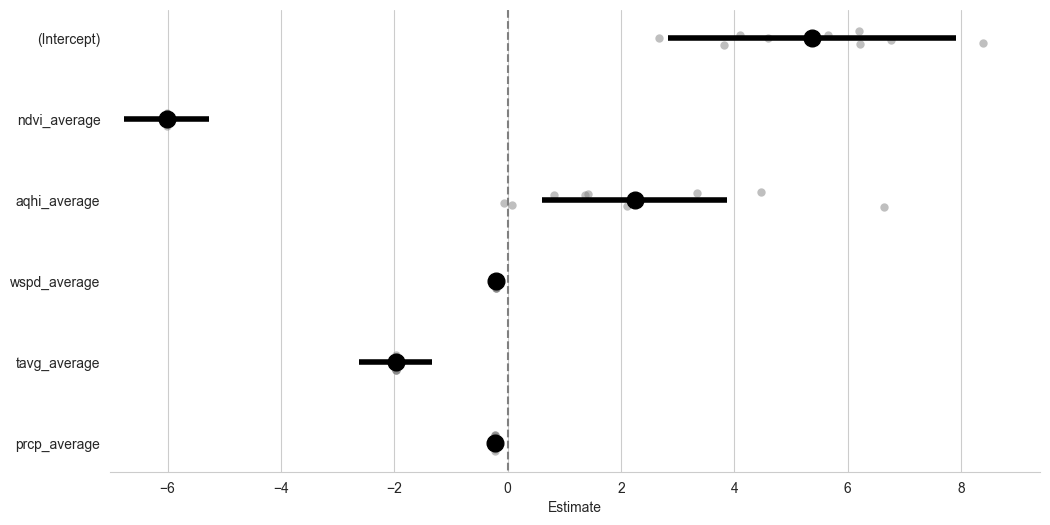

In [124]:
best_model.plot_summary()

### Higher skewness , means that death hive have right skewed distribution (more positive value)

Let's check these distribution of average (which is an aggregate but should show similar pattern)

<Axes: xlabel='aqhi_average_og', ylabel='Density'>

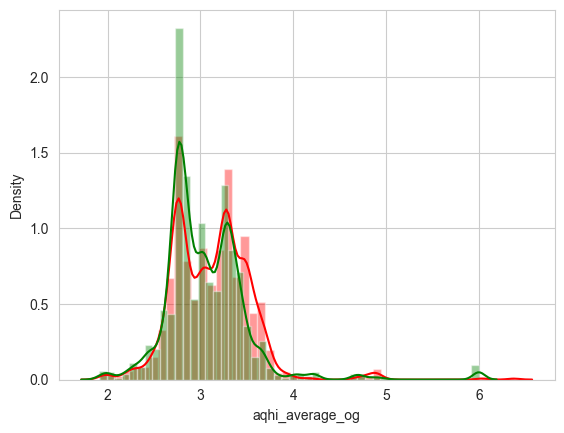

In [125]:
sns.distplot(data.loc[data['death_next_season']]['aqhi_average_og'], label="Death", color="red")
sns.distplot(data.loc[~data['death_next_season']]['aqhi_average_og'], label="Alive",color="green")

### Shallow learning approach 

In [126]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1250, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 40,60]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 20, 40,60]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [127]:
features = ['aqhi_average_og','tavg_average_og','tavg_max','tavg_skew'
            ,'wspd_average_og','wspd_skew','wspd_max','ndvi_skew','ndvi_max','ndvi_average'
            ,'prcp_average_og','prcp_skew','prcp_max']
data.season.value_counts()

season
2022    25035
2021     6247
Name: count, dtype: int64

In [128]:

mx=StandardScaler()

gr = pd.get_dummies(data['region'])
X = data.dropna(subset=['death_next_season','hive_age_next_season'],axis=0)
X.fillna(0,inplace=True)
X = X[features]
X = pd.concat([X,gr],axis=1)

data['death_next_season'] = data['death_next_season'].astype(bool)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    np.array(data.apply(lambda x: (x["death_next_season"], x["hive_age_next_season"]), axis=1).tolist(),dtype=[('cens', '?'), ('time', '<f8')]),
    test_size=0.15,
    random_state=8,
)

X_train = mx.fit_transform(X_train)
X_test = mx.transform(X_test)



In [129]:

rf = RandomSurvivalForest()

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=5,
    cv=3,
    verbose=1,
    random_state=8,
    n_jobs=-1,
)
# Fit the random search model
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomSurvivalForest(), n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 15, 21, 26, 32, 37,
                                                      43, 48, 54, 60, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [10, 20, 40, 60],
                                        'min_samples_split': [10, 20, 40, 60],
                                        'n_estimators': [100, 227, 355, 483,
                                                         611, 738, 866, 994,
                                                         1122, 1250]},
                   random_state=8, verbose=1)

In [130]:
rsf = rf_random.best_estimator_

SCORE
0.7381236201520575


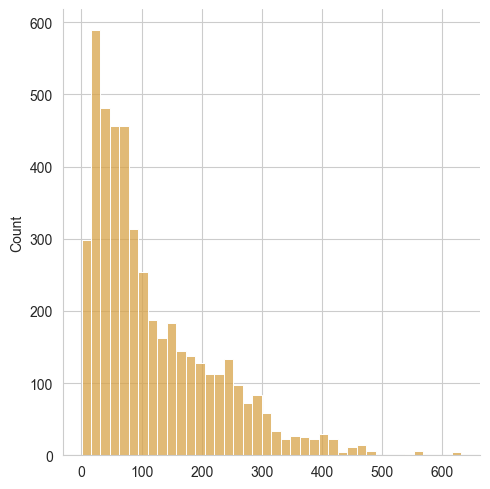

In [131]:
print("SCORE")
print(rsf.score(X_test,y_test))

sns.displot(rsf.predict(X_test))

### Evalutate

In [132]:
va_times = np.arange(300, 550, 7)
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(
    X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, rsf_risk_scores, va_times
)


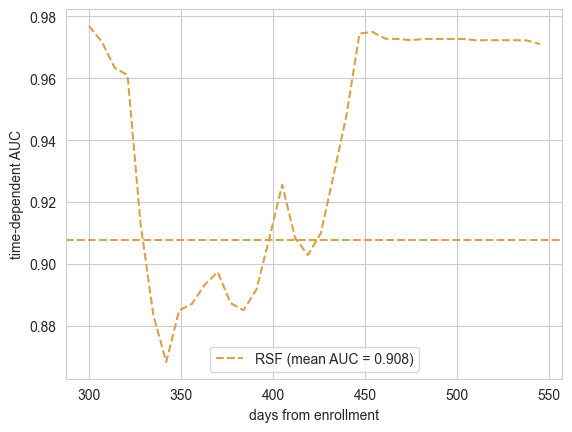

In [133]:
plt.plot(va_times, rsf_auc, "--", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
# I want to add the mean AUC to the plot
plt.axhline(rsf_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.savefig("ROC.png")
plt.grid(True)

### FEature importance

In [133]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    rsf, X_test, y_test, n_repeats=15, random_state=8
)

pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X.columns
).sort_values(by="importances_mean", ascending=False)


KeyboardInterrupt


KeyboardInterrupt



### Checking correlation between predictor variables

In [ ]:
# Computing the correlation matrix
correlation_matrix1 = X.corr()

In [ ]:
# Displaying the correlation matrix
print(correlation_matrix1)

In [ ]:
correlation_matrix1.describe()

In [ ]:
# Creating a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig("Heath map RSF1.jpg", dpi=300)
plt.show()

In [ ]:
### To check and plot the minimal variable depth and importance for covariate interactions in the RSF1

In [ ]:
# Getting the trees from the RFS
trees = rsf.tree_

# Calculating variable depth and importance for covariate interactions
variable_depth = np.zeros(X.shape[1])
variable_importance = np.zeros(X.shape[1])

for tree in trees:
    # Traverse the tree to calculate variable depth and importance
    stack = [(0, 0)]  # (node_id, depth)
    
    while stack:
        node_id, depth = stack.pop()
        
        # If the node is not a leaf, traverse its children
        if tree.children_left[node_id] != tree.children_right[node_id]:
            stack.append((tree.children_left[node_id], depth + 1))
            stack.append((tree.children_right[node_id], depth + 1))
        else:
            # Accumulate variable depth and importance
            variable_depth[tree.feature[node_id]] += depth
            variable_importance[tree.feature[node_id]] += tree.impurity[node_id] * tree.n_node_samples[node_id]

# Normalizing variable importance
variable_importance /= np.sum(variable_importance)

# Plot
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(X.columns, variable_depth, alpha=0.7, label='Variable Depth', color='b')
ax2.plot(X.columns, variable_importance, label='Variable Importance', color='r')

ax1.set_xlabel('Covariates')
ax1.set_ylabel('Variable Depth', color='b')
ax2.set_ylabel('Variable Importance', color='r')

plt.title('Minimal Variable Depth and Importance for Covariate Interactions')
plt.savefig("MVD_IMP_RSF1.jpg", dpi=300)
plt.show()

### Random Forest 2 without Region I want to check just this variables

In [ ]:
features = ['aqhi_average_og','tavg_average_og'
            ,'wspd_average_og','ndvi_average'
            ,'prcp_average_og']
data.season.value_counts()

In [ ]:
mx=StandardScaler()
X2 = data.dropna(subset=['death_next_season','hive_age_next_season'],axis=0)
X2.fillna(0,inplace=True)
X2 = X2[features]

data['death_next_season'] = data['death_next_season'].astype(bool)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2,
    np.array(data.apply(lambda x: (x["death_next_season"], x["hive_age_next_season"]), axis=1).tolist(),dtype=[('cens', '?'), ('time', '<f8')]),
    test_size=0.15,
    random_state=8,
)

X2_train = mx.fit_transform(X2_train)
X2_test = mx.transform(X2_test)

In [ ]:
rf2 = RandomSurvivalForest()
# I let the grid as you did
rf2_random = RandomizedSearchCV(
    estimator=rf2,
    param_distributions=random_grid,
    n_iter=5,
    cv=3,
    verbose=1,
    random_state=8,
    n_jobs=-1,
)
# Fit the random search model
rf2_random.fit(X2_train, y2_train)

In [ ]:
rsf2 = rf2_random.best_estimator_

print("Score RF2")
print(rsf2.score(X2_test,y2_test))

sns.displot(rsf2.predict(X2_test))

### EVALUATE

In [ ]:
va_times2 = np.arange(300, 550, 7)
rsf_chf_funcs2 = rsf2.predict_cumulative_hazard_function(
    X2_test, return_array=False)
rsf_risk_scores2 = np.row_stack([chf(va_times2) for chf in rsf_chf_funcs2])

rsf_auc2, rsf_mean_auc2 = cumulative_dynamic_auc(
    y2_train, y2_test, rsf_risk_scores2, va_times2
)

In [ ]:
plt.plot(va_times2, rsf_auc2, "--", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc2))
# I want to add the mean AUC to the plot
plt.axhline(rsf_mean_auc2, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.savefig("ROC2.png")
plt.grid(True)

### FEATURE IMPORTANCE

In [ ]:
from sklearn.inspection import permutation_importance
result2 = permutation_importance(
    rsf2, X2_test, y2_test, n_repeats=15, random_state=8
)



In [ ]:
rsf2df = pd.DataFrame({k: result2[k] for k in ("importances_mean", "importances_std",)},index=X2.columns).sort_values(by="importances_mean", ascending=False)
# Save DataFrame to CSV
rsf2df.to_csv('RF2_variable_importance_results.csv')

In [ ]:
rsf2df

### Checking correlation variables

In [ ]:
# Computing the correlation matrix
correlation_matrix2 = X2.corr()

In [ ]:
# Displaying the correlation matrix
print(correlation_matrix2)

In [ ]:
correlation_matrix2.describe()

In [ ]:
# Creating a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig("Heath map RSF2.jpg", dpi=300)
plt.show()

### Basic simulation

In [ ]:
def process(X, factor):
    X_copy = X.copy()
    X_copy[['aqhi_average_og']] = X[['aqhi_average_og']] * factor
    X_copy = mx.transform(X_copy)
    return X_copy
    

In [ ]:
def avg_surv_func(feat):
    surv = rsf.predict_survival_function(feat, return_array=True)
    return np.mean(surv,axis=0)

In [ ]:
X.head()

In [ ]:
preds = avg_surv_func(process(X, 1))
preds2 = avg_surv_func(process(X, 1.1))
preds3 = avg_surv_func(process(X, 1.5))
preds4 = avg_surv_func(process(X, 2))
preds8 = avg_surv_func(process(X, 4))


In [ ]:
predictions = np.stack([preds,preds2,preds3,preds4,preds8],axis=1,dtype=np.float32).flatten()
predictions.shape

In [ ]:
temps = []
for _ in [1.0,1.1,1.5,2.0,4.0]:
    temps.append([i for i in range(len(preds))])

In [ ]:
temps = np.stack(temps,axis=1).flatten()
temps.shape

In [ ]:
factor = []
for ii in [1.0,1.1,1.5,2.0,4.0]:
    f = []
    for _ in range(len(preds)):
        f.append([f"{ii}x"])
    factor.append(f)
factor = np.stack(factor,axis=1).flatten()
factor.shape

In [ ]:
results = pd.DataFrame({"Probabilité de survie":predictions,"Temps":temps, "Facteur":factor})
results.head()

In [ ]:
LANG = "EN"
title = {"FR":"Fonction de survie attendue dans des simulations \n d'intensification de mauvaise qualité de l'air",
         "EN":"Expected survival function for different simulations with varying air quality"}
xaxe = {"FR": "Temps (en jours)","EN":"Time (days)"}
yaxe = {"FR": "Probabilité de survie", "EN":"Probability of survival"}


sns.lineplot(x=results['Temps'], y=results['Probabilité de survie'], hue=results["Facteur"], linewidth=3, alpha=0.85, linestyle="solid")
plt.ylabel(yaxe[LANG])
plt.xlabel(xaxe[LANG])
plt.title(title[LANG])
plt.legend()
plt.grid(True)
plt.savefig(f"figure-2-{LANG}.png")

### Pred on 2023 true value

In [ ]:
next_year.head()

### Conclusion and next steps 

In [ ]:
next_year['wspd_average_og'] = next_year['wspd_average']
next_year['tavg_average_og'] = next_year['tavg_average']
next_year['prcp_average_og'] = next_year['prcp_average']
next_year['aqhi_average_og'] = next_year['aqhi_average']

next_year['wspd_average'] = np.log(next_year['wspd_average']+10e-5)
next_year['tavg_average'] = np.log(next_year['tavg_average']+10e-5)
next_year['prcp_average'] = np.log(next_year['prcp_average']+10e-5)
next_year['aqhi_average'] = np.log(next_year['aqhi_average']+10e-5)

In [ ]:
gr_next_year = pd.get_dummies(next_year['region'])
X_next_year = next_year.dropna(subset=['death_next_season','hive_age_next_season'],axis=0)
X_next_year.fillna(0,inplace=True)
X_next_year = X_next_year[features]
X_next_year = pd.concat([X_next_year,gr_next_year[gr.columns]],axis=1)

In [ ]:
X_next_year.head()

In [ ]:
transformed = mx.transform(X_next_year)

In [ ]:
surv23 = avg_surv_func(transformed)

In [ ]:
tim = [2023 for _ in range(len(surv23))]
tim.extend([2022 for _ in range(len(preds))])

In [ ]:
times = [i for i in range(len(surv23))]
times.extend([i for i in range(len(preds))])

In [ ]:
predics = surv23.tolist()
predics.extend(preds.tolist())

In [ ]:
ny = pd.DataFrame({"pred":predics, "year":tim, "time":times})
ny.head()

In [ ]:
LANG = "EN"
title = {"FR":"Fonction de survie attendue pour 2023",
         "EN":"Expected survival function for 2023"}
xaxe = {"FR": "Temps (en jours)","EN":"Time (days)"}
yaxe = {"FR": "Probabilité de survie", "EN":"Probability of survival"}


sns.lineplot(x=ny['time'], y=ny['pred'],hue=ny['year'],linewidth=3, alpha=0.85, linestyle="solid")
plt.ylabel(yaxe[LANG])
plt.xlabel(xaxe[LANG])
plt.title(title[LANG])
plt.legend()
plt.grid(True)
plt.savefig(f"figure-3-{LANG}.png")

### To be improve 

- We need to make sure 2022 and 2023 compare the same beekeepers to avoid the power bias and sampling bias as much as possible
- Explore more the AQHI index VS individual compoennts/gaz 
- More advanced predicting modeling (neuralnets...)